#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [16]:
!pip install requests

In [17]:
import torchvision.datasets

Download the dataset:

In [18]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 5


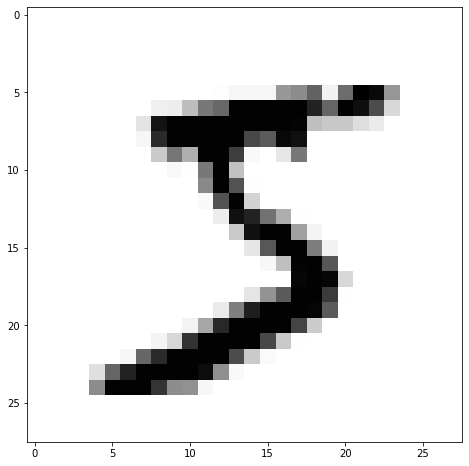

In [19]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [20]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [21]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


Import all needed packages

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset
from torch.autograd import Variable
from sklearn.model_selection import KFold
from torchvision import transforms, datasets
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output

#set seed for reproducibility
seed = 753
np.random.seed(seed)
torch.manual_seed(seed)

#Use as "hyper-hyper" param
batch_size = 512

# Check if a cuda GPU is available and eventually select it
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU available")
else:
  device = torch.device("cpu")
  print("GPU NOT available")

GPU NOT available


In [23]:
class EarlyStopping:
    '''
    This class monitors whether a metrics does not improve over some
    number of epochs, and eventually stop the training
    '''

    def __init__(self, patience = 10, delta = 1e-5, path = "checkpoint.torch", verbose = False ):
        '''
        patience : how many iterations to wait after last improvement (default: 10)
        delta    : the minimum improvement one might consider (default: 1e-5)
        path     : where to save the best model so far (default: "checkpoint.torch")
        verbose  : whether to print some logs (eventual improvements (default: False))
        '''

        self.patience = patience
        self.counter  = 0
        self.delta    = delta
        self.verbose = verbose
        self.path    = path

        self.metrics_min = np.Inf
        self.early_stop  = False
        self.best_score  = None

    def __call__(self, metrics, model):
        actual_score = -metrics

        #this occurs at the first time step
        if self.best_score is None:
            self.best_score = actual_score 
            self.save_checkpoint(metrics, model)

        #if there is already a best score and no improvement
        elif actual_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        #if there is improvement, then restart the counter
        else:
            self.best_score = actual_score
            self.save_checkpoint(metrics, model)
            self.counter = 0
    
    def save_checkpoint(self, metrics, model):
        '''
        Save as a checkpoint the model when the metrics decrease
        '''
        if self.verbose:
            print("Actual metrics has decreased: ", self.metrics_min , " ---> ", metrics ,)
        torch.save(model.state_dict(), self.path)
        self.metrics_min = metrics


In [24]:
class Network(nn.Module):
    def __init__(self, n_channels = 1 , drop = 0.):
        '''
        Constructor that builds a Convolutional Neural Network with (in order)
        - 1 Convolutional layer + stride
        - 1 Convolutional layer + stride
        - Flattening
        - 1 Dense layer + Dropout 
        - 1 Dense layer (10 units) -> OUTPUT
        ======================================================
        INPUT
         - drop (float)    : probability of dropout for the two dense layers
         - n_channels(int) : number of output channels of the first layer
        ======================================================
        '''
        super().__init__()

        self.batch_size = n_channels
        flatten_dim = (2*n_channels)*5*5

        #Network architecture related code
        #in order to reduce halve the dimensionality, the stride parameter is 2
        # ---> img size 28x28 -> 14x14
        self.conv1 = nn.Conv2d(in_channels = 1,  out_channels = n_channels, kernel_size = 4, padding=1, stride = 2)
        # ---> img size 14x14 -> 5x5
        self.conv2 = nn.Conv2d(in_channels = n_channels, out_channels = 2*n_channels, kernel_size=5, stride = 2)

        #fully connected layers
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.out = nn.Linear(128, 10)
        
        #Activation function related code 
        self.relu  = nn.ReLU()

        #Dropout related code
        self.drop = nn.Dropout(p = drop)
        
        #print("Network initialized!")


    def forward(self, x, additional_out=False):
        # print("\n", x.shape )
        #first convolutional layer
        x = self.relu(self.conv1(x))
        # print(x.shape )
        #second convolutional layer
        x = self.relu(self.conv2(x))
        # print(x.shape )
        #flatten up to first connected layer + dropout
        x = x.view(x.size(0), -1)
        # print(x.shape )
        x = self.relu(self.drop(self.fc1(x)))
        #second connected layer -> output
        x = self.out(x)

        return x
    
    def train_epoch(self, train_data_loader, loss_function, optimizer, device):
        '''
        Train the network (self) using as input eventual batches from train_data_loader,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.train()
        ### TRAIN
        train_loss = []
        for i_batch, sample_batched in enumerate(train_data_loader):

            #divide the batch into values and labels
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            #Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss_mean = np.mean(train_loss)
        train_loss_std  = np.std(train_loss)

        return train_loss_mean, train_loss_std


    def eval_epoch(self, eval_data_loader, loss_function, optimizer, device):
        '''
        Evaulate the performance of network (self)
        using as input the validation set,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.eval()
        val_loss = []
        
        with torch.no_grad(): # Disable gradient tracking
            for i_batch, sample_batched in enumerate(eval_data_loader):
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)

                # Compute loss
                loss = loss_function(out, label_batch)
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        # Save average val loss
        val_loss_mean = np.mean(val_loss)
        val_loss_std  = np.std(val_loss)

        return val_loss_mean, val_loss_std

    #training WITHOUT early stopping
    def fit(self, train_data, val_data, params_dict, loss_fn, plot_flag = False):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        device = params_dict.get('device')

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.eval_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        if (plot_flag):
            plt.figure(figsize = (8,6))
            plt.plot(train_metrics[0,:], label = 'train')
            plt.plot(val_metrics[0,:], label = 'test')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss vs epochs')
            plt.legend()
            plt.show()

        return train_metrics, val_metrics

    #training WITH early stopping
    def fit_early_stop(self, train_data, val_data, params_dict, loss_fn,
            early_stop_flag = False, patience = 10, verbose = False):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        device = params_dict.get('device')
        
        #train with early stopping 
        if early_stop_flag: 
            early_stop = EarlyStopping(patience, verbose = verbose)

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.eval_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)

            #use early stop if the flag is set to True
            if early_stop_flag:
                early_stop(loss_mean, self)
                if early_stop.early_stop:
                    print("Loss has not increased. Early stopping...")
                    break

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        return train_metrics, val_metrics
    
    def test(self, test_loader, params_dict):
        '''
        Test the network in a classification task
        '''
        wrong_label = 0
        predictions = []
        true_labels = []

        self.eval()
        device = params_dict.get('device')
        # Disable gradient tracking
        with torch.no_grad():
            for sample_batched in test_loader:
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy().argmax()

                predictions.append(out)
                true_labels.append(label_batch)
                
        num_samples = len(test_loader)
        temp_list = [predictions[i]-true_labels[i] for i in range(num_samples)]
        #"zero" elements are the correct ones
        accuracy = temp_list.count(0)/num_samples
        return accuracy

    def predict(self, data_input, device):
        '''
        Compute an array of predicted labels given input data
        '''
        #set evaluation mode
        self.eval()
        predictions_list = []

        #disable gradient computing/tracking
        with torch.no_grad():
            for i_batch, sample_batched in enumerate(data_input):
                x_batch = sample_batched[0].to(device) 
                #Forward pass
                out = self.forward(x_batch)
                outputs = out.cpu().numpy().argmax()

                predictions_list.append(outputs)
        return np.array( predictions_list )

    #save the network state onto a path passed as input
    def save_net(self, path: str):
        torch.save( self.state_dict(), path )
    
    #retrieve the network state from a path passed as input
    def load_net(self, path: str):
        self.load_state_dict( torch.load(path) )

In [6]:
class AddGaussianNoise():
    def __init__(self, mu = 0., std = 1.):
        self.mu  = mu
        self.std = std

    def __call__(self, tensor : torch.tensor):
        perturb = torch.randn(tensor.size(), device=tensor.device) * self.std
        return tensor + perturb + self.mu

In [7]:
# As soon as data is uploaded, compose two basic transformations:
# ToTensor()
# Normalize by 
#    - mean = 0.1307 
#    - std  = 0.3081

basic_transf = transforms.Compose( [
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                    ] )

In [8]:
test_dataset  = datasets.MNIST('classifier_data', train=False, transform=basic_transf, download=True)

In [9]:
Gauss_noise = AddGaussianNoise()
Rotation    = transforms.RandomRotation(degrees = 45)

advanced_transform = transforms.Compose([basic_transf,
                                        transforms.RandomChoice([Gauss_noise,Rotation])
                                        ]) 

In [10]:
train_dataset_full = datasets.MNIST('classifier_data', train=True,  transform = advanced_transform, download=True)

TRAIN_PERC = 0.8
TRAIN_ELEM = len(train_dataset_full)
N_TRAIN_ELEM = int(TRAIN_ELEM*TRAIN_PERC) 
N_VALID_ELEM = TRAIN_ELEM - N_TRAIN_ELEM
N_TEST_ELEM  = len(test_dataset)

print("Elements in Train set:",      N_TRAIN_ELEM)
print("Elements in Validation set:", N_VALID_ELEM)
print("Elements in Test set:",       N_TEST_ELEM )

# Prepare Training and Validation sets
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset_full, [N_TRAIN_ELEM, N_VALID_ELEM])

Elements in Train set: 48000
Elements in Validation set: 12000
Elements in Test set: 10000


In [11]:
batch_size_train = 512
batch_size_test  = 1

#load the data
train_load = torch.utils.data.DataLoader(train_dataset,      batch_size=batch_size_train, shuffle = True)
valid_load = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size_train, shuffle = False)
test_load  = torch.utils.data.DataLoader(test_dataset,       batch_size=batch_size_test,  shuffle = False)

100% 15/15 [05:45<00:00, 23.02s/it]


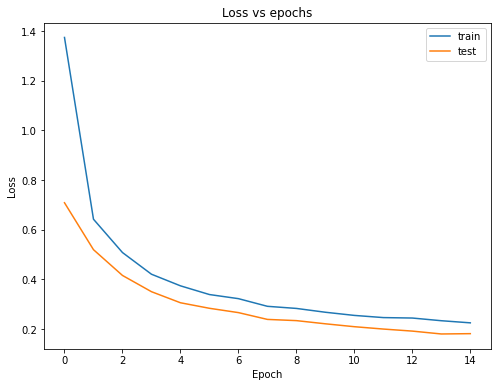

(array([[1.3743241 , 0.64213777, 0.5079115 , 0.42055166, 0.37380576,
         0.33867708, 0.32211852, 0.29126462, 0.28273845, 0.2673334 ,
         0.25460425, 0.24582806, 0.24401927, 0.23321214, 0.2246616 ],
        [0.56977713, 0.07635549, 0.0489049 , 0.0440614 , 0.04005289,
         0.03577608, 0.03741112, 0.04082677, 0.03527149, 0.03114396,
         0.03265634, 0.03533594, 0.02991461, 0.03167353, 0.03245888]],
       dtype=float32),
 array([[0.70846707, 0.51944   , 0.4156369 , 0.35018286, 0.30558947,
         0.2832851 , 0.2658712 , 0.23850848, 0.23360391, 0.22079253,
         0.2091155 , 0.19963317, 0.1913944 , 0.17981504, 0.18109961],
        [0.04036639, 0.04146018, 0.0298141 , 0.02846978, 0.02724822,
         0.03008051, 0.03731836, 0.02675414, 0.03098571, 0.02501254,
         0.03005974, 0.0225039 , 0.03140713, 0.0316094 , 0.02286295]],
       dtype=float32))

In [19]:
test_network = Network(2, 0.25).to(device)
multiclass_loss = nn.CrossEntropyLoss()

fit_dict = {'device': device, 
            'optimizer': optim.Adam(test_network.parameters()) ,
            'n_epochs': 15
            }

test_network.fit(train_data = train_load, val_data = valid_load, params_dict = fit_dict, loss_fn = multiclass_loss, plot_flag = True)

In [20]:
print("Simple model without optimization accuracy is: ", test_network.test( test_load , fit_dict ))

Simple model without optimization accuracy is:  0.9685


In [21]:
#Analyze the predictions with a confusion matrix
predictions = test_network.predict( test_load , fit_dict.get('device'))
true_labels = np.array([x[1] for x in test_dataset])

Let us check the performance on the test set.

Labels and frequencies in test set:  [ 980 1135 1032 1010  982  892  958 1028  974 1009]

 Confusion matrix (normalized)


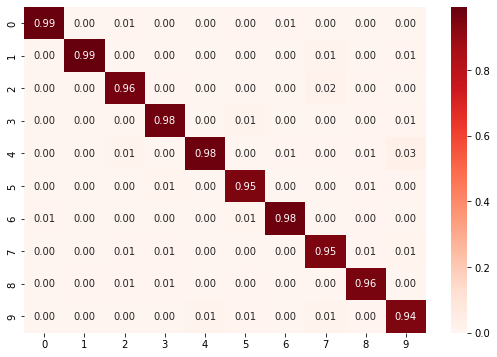

In [22]:
# for better aligned printing of confusion matrix use floatmode='fixed' (not supported in all versions of Python)
np.set_printoptions(precision=3, suppress=True, floatmode = 'fixed')

u, counts = np.unique(true_labels, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_test = skm.confusion_matrix( predictions, true_labels)

print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(confusion_test/counts[:,None], annot=True, fmt =  "1.2f" , cmap="Reds" )
plt.show()

# Best hyperparameters search

In [23]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('learn_r')
    w_dec   = params_dict.get('weight_dec')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr = learn_r,
            weight_decay = w_dec,
            momentum = 0.9
            )

    elif params_dict.get('optimizer') == 'adam':
        optimizer = optim.Adam(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec,
        )

    elif params_dict.get('optimizer') == 'adagrad':
        optimizer = optim.Adagrad(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_dec
        )

    return optimizer

#reset parameters to avoid weights leakage
#source https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/
def reset_weights(model):
    if isinstance(model, nn.Linear):
        model.reset_parameters()

In [24]:
hyper_param_dict = {
    'n_channels' : [2,4,8,16],
    'drop'       : np.random.uniform(0, 0.5, size = 20),
    'optimizer'  : ['sgd', 'adagrad', 'adam'],
    'learn_r'    : loguniform.rvs(1e-4, 1e-2, size =  20),
    'weight_dec' : loguniform.rvs(1e-3, 1e-1, size =  20), #acts similarly to L2 norm
    'device'     : [device]
}

#sample a single set of parameters out
def sample_set_params(params_urn):
  drawn = {}
  for param in params_urn.keys():
    drawn[param] = np.random.choice( params_urn.get(param) )

  return drawn

sample_set_params(hyper_param_dict)

{'n_channels': 8,
 'drop': 0.18937947207633532,
 'optimizer': 'adagrad',
 'learn_r': 0.0016612411672599745,
 'weight_dec': 0.00903777247297268,
 'device': device(type='cpu')}

In [25]:
def CV_random_set(train_set, valid_set, params_grid, iterations):
    '''
    This functions tries a given number of set of parameters, in order
    to find the optimal set of parameters which reaches the least validation loss
    Since data is few, the search is done after splitting the training data into
    a certain number of folds (K-FOLD cross validation)
    INPUTS:
    - train_set   : training set dataloader
    - valid_set   : validation set dataloader
    - params_grid : a dictionary with the parameters one draws from
    - iterations  : number of set of parameters to test

    OUTPUT:
    A dictionary containing: 
    - the set of parameters chosen
    - training loss for every epoch
    - validation loss for every epoch
    '''

    output_dict = {}
    parameters_list     = []
    train_loss_log      = []
    validation_loss_log = []

    #the loss remains the same due to the nature of the problem
    loss = nn.CrossEntropyLoss()

    for iterat in range(iterations):
        print("\n ################ MODEL", iterat+1, "/", iterations, "  ###########")

        #"draw" a model
        actual_params = sample_set_params(params_grid)
        parameters_list.append(actual_params)

        n_channels = actual_params.get('n_channels')
        drop = actual_params.get('drop')
        optimizer = actual_params.get('optimizer')
        learn_r = actual_params.get('learn_r')
        weight_dec = actual_params.get('weight_dec')
        device = actual_params.get('device')

        #create new network with given parameters and reset weights
        network = Network(n_channels=n_channels, drop=drop).to(device)
        network.apply(reset_weights)

        optimizer = get_correct_optimizer(network, actual_params)

        #instantiate this dummy dict due to "fit" method implementation
        dummy_dict = {'optimizer': optimizer, 'n_epochs': 40, 'device': device}
        #do the job -> training and validation over a single fold
        train_loss, val_loss = network.fit_early_stop(train_set, valid_set, dummy_dict, loss,
                                                      early_stop_flag = True, patience = 2, verbose = False)
                
        #fold is an index that denotes the fold we are dealing with
        train_loss_log.append(train_loss)
        validation_loss_log.append(val_loss)
        clear_output(wait=True)
        del network 


    return  parameters_list, train_loss_log, validation_loss_log 

In [27]:
pars, train_loss, val_loss = CV_random_set(train_load, valid_load, hyper_param_dict, 40)

  0% 0/40 [00:00<?, ?it/s]


 ################ MODEL 40 / 40   ###########


 78% 31/40 [08:33<02:29, 16.57s/it]

Loss has not increased. Early stopping...


In [28]:
#train loss and val loss are array of the form (mean, std), we only need the means
train_loss_means = [i[0] for i in train_loss]
val_loss_means   = [i[0] for i in val_loss] 
results = pd.DataFrame([pars, train_loss_means, val_loss_means]).T
results.columns = ['params', 'training_loss', 'val_loss']
results['min_validation_loss'] = results.val_loss.apply(lambda x: np.min(x))
results = results.sort_values('min_validation_loss').reset_index(drop = True)
results.to_csv('results_classification.csv')
results

,params,training_loss,val_loss,min_validation_loss
0,"{'n_channels': 16, 'drop': 0.02817768022328398...","[0.8898967, 0.3407809, 0.20917393, 0.16650707,...","[0.4575217, 0.26059195, 0.18667488, 0.15633737...",0.088045
1,"{'n_channels': 16, 'drop': 0.22302022243092595...","[0.83482814, 0.3278432, 0.22072555, 0.18264301...","[0.38638583, 0.23233855, 0.17410655, 0.1657085...",0.089959
2,"{'n_channels': 16, 'drop': 0.38213248697702573...","[0.5792924, 0.22264324, 0.17648081, 0.16634105...","[0.1972748, 0.14666845, 0.122784376, 0.1262692...",0.095368
3,"{'n_channels': 16, 'drop': 0.00773454787468907...","[1.6308849, 0.5527505, 0.3932998, 0.30580536, ...","[0.6850013, 0.47238564, 0.34414133, 0.2761601,...",0.096561
4,"{'n_channels': 8, 'drop': 0.4067313626364476, ...","[1.1956961, 0.56392616, 0.425091, 0.34960377, ...","[0.59107614, 0.42293906, 0.32772732, 0.2623908...",0.100737
5,"{'n_channels': 8, 'drop': 0.20897402166044182,...","[0.67622346, 0.23983467, 0.18638982, 0.1650559...","[0.2754961, 0.17497301, 0.16552223, 0.13376696...",0.108436
6,"{'n_channels': 4, 'drop': 0.09613300749628806,...","[1.2288593, 0.53507835, 0.38181752, 0.2960934,...","[0.639452, 0.44612765, 0.31577003, 0.26801154,...",0.110823
7,"{'n_channels': 4, 'drop': 0.044543102133377976...","[1.1731461, 0.45684645, 0.2996436, 0.23786005,...","[0.5837737, 0.35350847, 0.25755623, 0.2309198,...",0.113150
8,"{'n_channels': 4, 'drop': 0.22302022243092595,...","[1.2980487, 0.56127965, 0.40803906, 0.33027872...","[0.62531424, 0.43255985, 0.328291, 0.27020267,...",0.121050
9,"{'n_channels': 16, 'drop': 0.10828452680128925...","[0.49477947, 0.18771113, 0.1661245, 0.15101628...","[0.1887173, 0.20132558, 0.1527806, 0.13977079,...",0.124751


In [29]:
print("Best set of parameters is: ------>" )
opt_set = results.params[0]
print(opt_set)

Best set of parameters is: ------>
{'n_channels': 16, 'drop': 0.028177680223283985, 'optimizer': 'adam', 'learn_r': 0.0008813867151903676, 'weight_dec': 0.0026925644098330795, 'device': device(type='cpu')}


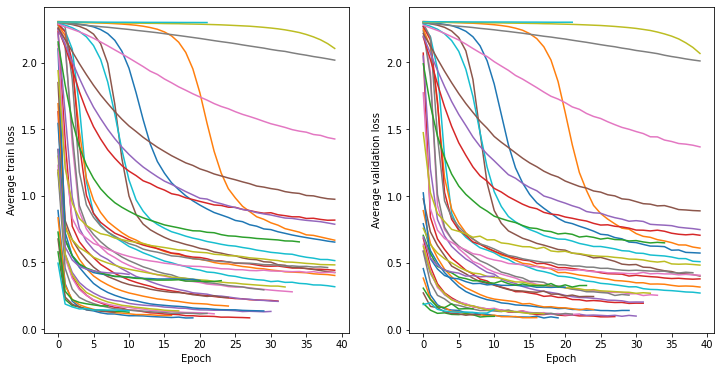

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
for i in results.iterrows():
    ax[0].plot(i[1].training_loss)
    ax[1].plot(i[1].val_loss)
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Average train loss')
ax[1].set_ylabel('Average validation loss')

plt.show()

# Best network

In [31]:
n_channels = opt_set.get('n_channels')
drop = opt_set.get('drop')
optimizer = opt_set.get('optimizer')
learn_r = opt_set.get('learn_r')
weight_dec = opt_set.get('weight_dec')
device = opt_set.get('device')

In [32]:
#instantiate the best network
best_network = Network(n_channels = n_channels, drop = drop).to(device)
best_network.apply(reset_weights)
optimizer = get_correct_optimizer(best_network, opt_set)
#instantiate this dummy dict due to "fit" method implementation
dummy_dict = {'optimizer': optimizer, 'n_epochs': 60, 'device': device} 
loss_function = nn.CrossEntropyLoss()

train, test = best_network.fit_early_stop(train_load, valid_load, dummy_dict, loss_function,
                                          True, 5)

 40% 24/60 [06:38<09:57, 16.61s/it]

Loss has not increased. Early stopping...


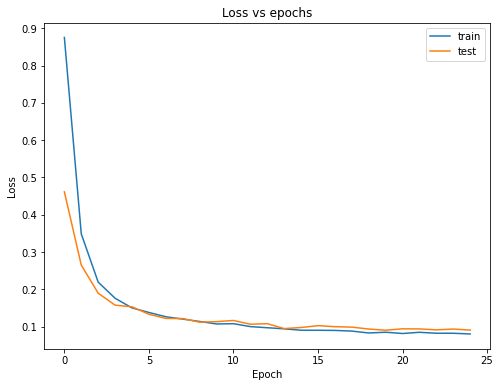

In [33]:
#manual plotting
plt.figure(figsize = (8,6))
plt.plot(train[0,:], label = 'train')
plt.plot(test[0,:], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.legend()
plt.show()

In [59]:
#save the network and the optimizer
best_params_dict = best_network.state_dict()
torch.save(best_params_dict, 'best_net_params_classification.torch')
# save the optimizer
torch.save(optimizer.state_dict(), 'best_net_optimizer_classification.torch')

In [26]:
best_network = Network(n_channels = 16, drop = 0.028177680223283985).to(device)
best_network.load_net('best_net_params_classification.torch')

In [30]:
fit_dict = {'device': device, 
            'optimizer': optim.Adam(best_network.parameters()) ,
            'n_epochs': 15
            }

Simple model without optimization accuracy is:  0.9858
Labels and frequencies in test set:  [ 980 1135 1032 1010  982  892  958 1028  974 1009]

 Confusion matrix (normalized)


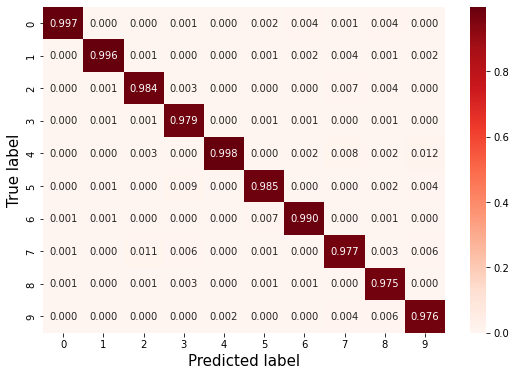

In [33]:
print("Simple model without optimization accuracy is: ", best_network.test( test_load , fit_dict ))
#Analyze the predictions with a confusion matrix
predictions = best_network.predict( test_load , fit_dict.get('device'))
true_labels = np.array([x[1] for x in test_dataset])

# for better aligned printing of confusion matrix use floatmode='fixed' (not supported in all versions of Python)
np.set_printoptions(precision=4, suppress=True, floatmode = 'fixed')

u, counts = np.unique(true_labels, return_counts=True)
print("Labels and frequencies in test set: ", counts)

confusion_test = skm.confusion_matrix( predictions, true_labels)

print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(confusion_test/counts[:,None], annot=True, fmt =  "1.3f" , cmap="Reds" )
plt.ylabel('True label', fontsize = 15)
plt.xlabel('Predicted label', fontsize = 15)
plt.show()

# Weights

### Convolutional layers

In [35]:
# First hidden layer
conv1_weights = best_network.conv1.weight.data.cpu().numpy()
conv2_weights = best_network.conv2.weight.data.cpu().numpy()

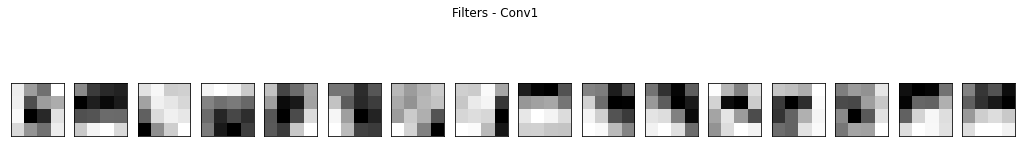

In [36]:
fig, ax = plt.subplots(1,int(opt_set['n_channels']), figsize=(18, 3))

for i in range(int(opt_set['n_channels'])):
    ax[i].imshow( conv1_weights[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters - Conv1 ', fontsize = 12)
plt.savefig('filters_CL1_1.png')
plt.show()

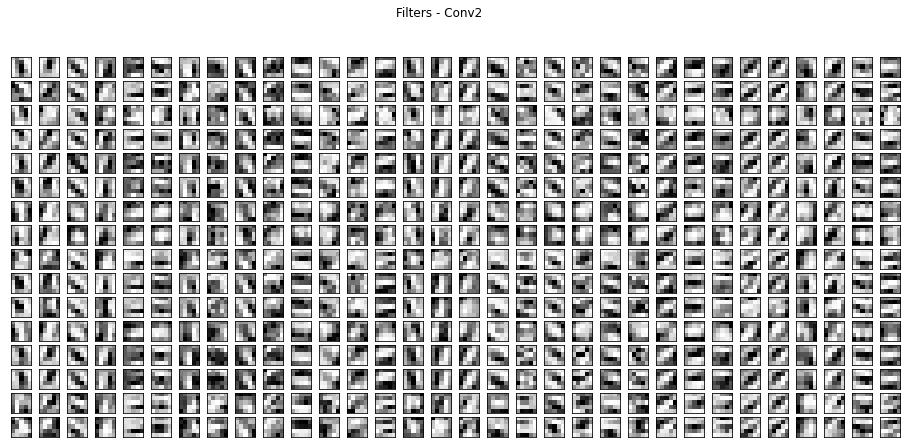

In [37]:
fig, ax = plt.subplots(int(opt_set['n_channels']), 2*int(opt_set['n_channels']), figsize=(16, 7))

for i in range(int(opt_set['n_channels'])):
    for j in range(2*int(opt_set['n_channels'])):
        ax[i,j].imshow( conv2_weights[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig.suptitle('Filters - Conv2 ', fontsize = 12)
plt.savefig('filters_CL1_2.png')
plt.show()

### Dense layers

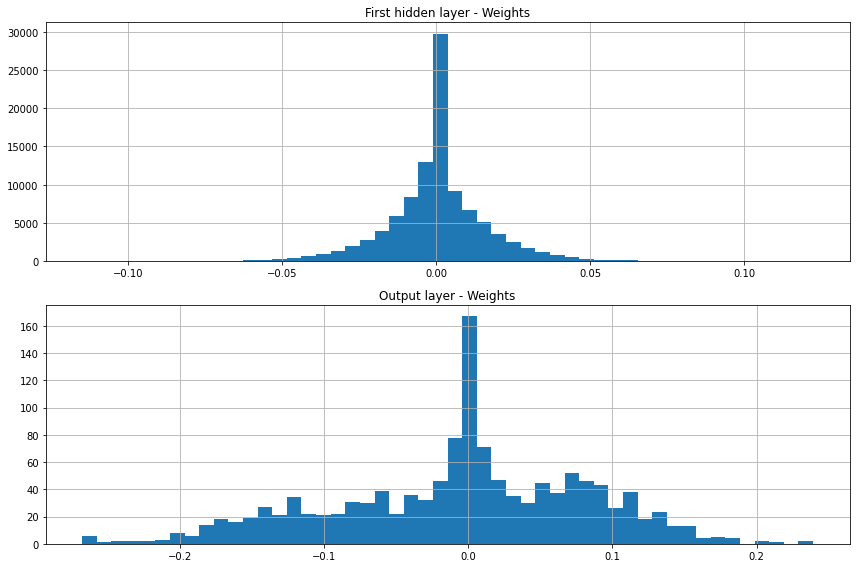

In [38]:
# First hidden layer
h1_weight = best_network.fc1.weight.data.cpu().numpy()
h1_bias   = best_network.fc1.bias.data.cpu().numpy()

# Second hidden layer
out_weight = best_network.out.weight.data.cpu().numpy()
out_bias   = best_network.out.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs[0].hist(h1_weight.flatten(), 50)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(out_weight.flatten(), 50)
axs[1].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

# Activations

In [39]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

### First layer

In [40]:
### Register hook  
hook_handle1 = best_network.conv1.register_forward_hook(get_activation)

#load a single image
image_test = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

### Analyze activations
best_network.to(device).eval()

with torch.no_grad():
    for s_batch in image_test:
        #save this image to be used later
        my_image = s_batch
        # Move data to device
        x_first = my_image[0].to(device)
        # Forward pass
        y_first = best_network(x_first)
        z_first = activation
        break

first_conv_layer_act = z_first.cpu().numpy()
### Remove hook
hook_handle1.remove()

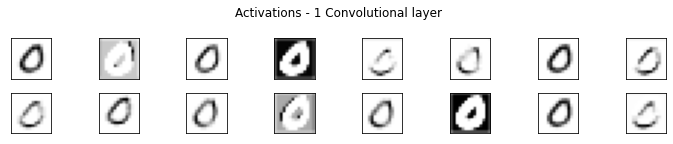

In [58]:
## Plot the activations
fig, ax = plt.subplots(2, int(opt_set.get('n_channels')/2), figsize=(10,2))
for i in range(int(opt_set.get('n_channels'))):
    ax[i%2, i//2].imshow( first_conv_layer_act[0, i, :, :], cmap='Greys')
    ax[i%2, i//2].set_xticks([])
    ax[i%2, i//2].set_yticks([])

fig.suptitle('Activations - 1 Convolutional layer', fontsize = 12)    
plt.tight_layout()
plt.savefig('Conv1.png')
plt.show()   

### Second layer

In [42]:
### Register hook  
hook_handle2 = best_network.conv2.register_forward_hook(get_activation)

with torch.no_grad():
    for s_batch in image_test:
        my_image = s_batch
        # Move data to device
        x_sec = my_image[0].to(device)
        # Forward pass
        y_sec = best_network(x_sec)
        z_sec = activation
        break
        
sec_conv_layer_act = z_sec.cpu().numpy()
### Remove hook
hook_handle2.remove()

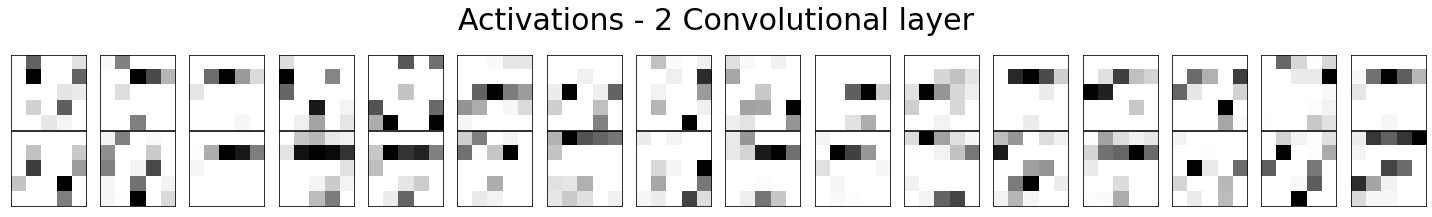

In [53]:
## Plot the activations
fig, ax = plt.subplots(2, int(opt_set.get('n_channels')), figsize=(20,3))
for i in range(int(2*opt_set.get('n_channels'))):
    ax[i%2, i//2].imshow( sec_conv_layer_act[0, i, :, :], cmap='Greys')
    ax[i%2, i//2].set_xticks([])
    ax[i%2, i//2].set_yticks([])

fig.suptitle('Activations - 2 Convolutional layer', fontsize = 30)    
plt.tight_layout()
plt.savefig('Conv2.png')
plt.show()   

The true label of this sample is: 1


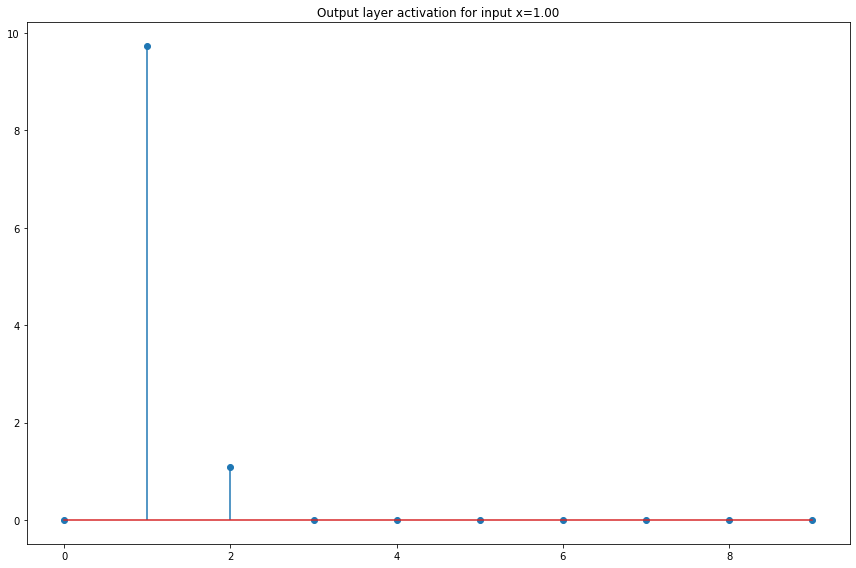

In [44]:
### Register hook  
hook_handle_fin = best_network.out.register_forward_hook(get_activation)

with torch.no_grad():
    for s_batch in image_test:
        # Move data to device
        x_fin = s_batch[0].to(device)
        # Forward pass
        y_fin = best_network(x_fin)
        z_fin = activation

print("The true label of this sample is:", int(s_batch[1][0].numpy()))
final_layer_act = z_fin.cpu().numpy()
### Remove hook
hook_handle_fin.remove()



### Plot activations
fig, axs = plt.subplots(1, 1, figsize=(12,8))
axs.stem(final_layer_act[0,:], use_line_collection=True)
axs.set_title('Output layer activation for input x=%.2f' % int(s_batch[1][0].numpy()))

plt.tight_layout()
plt.show()